# Hierarchical pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the values of L, $\theta$, and $a_g$ for each individual pendulum using a hierarchical setup.

In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
from jax import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
import arviz as az
import corner

In [2]:
# plotting and analysis utilities
def display_pendulum_data(df):
    color_list = ['#BCF4F5', '#B4EBCA', '#D9F2B4', '#D3FAC7','#FFB7C3']
    index = 0
    for pend in np.unique(df['pendulum_id']):
        subset = df[df['pendulum_id']==pend]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = pend)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        if pend > 3:
            break
        index+=1
    plt.legend()
    plt.show()

    index = 0
    for planet in np.unique(df['planet_id']):
        subset = df[df['planet_id']==planet]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = planet)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        if planet > 3:
            break
        index+=1
    plt.legend()
    plt.show()
    
def plot_prior_predictive(prior_pred, variable_model, variable_df, n_steps=10, title = None):
    label = "prior samples"
    plt.hist(
        prior_pred[variable_model].flatten(),
        n_steps,
        #range=(0.2, 3.0),
        #histtype="step",
        color="k",
        lw=0.5,
        alpha=0.5,
        label=label,
        density=True
    )


    plt.hist(df[variable_df], n_steps, histtype="step", color="black", label="data", density=True)
    plt.legend()
    plt.xlabel(variable_model)
    plt.ylabel("density")
    plt.title(title)
    plt.show()

# So because the sampler chain doesn't save the position at each point in time
# i have created a thing that samples position for us
def pos_calculator(L, theta, a_g, sigma, time):
    pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L)) * time) + sigma * np.random.randn(len(time))
    return pos

def how_did_we_do_on_individual_pendulums(df, posterior, n_pendulums, chain_length):
    for number in range(n_pendulums):
        sub_df = df[df['pend_code'] == number]
        print(f"Pendulum number {number}")
        print(f"true L = {np.mean(sub_df['length'].values)}")
        print(f"posterior L = {round(np.median(posterior['L'][:,number]),2)} +/- {round(np.std(posterior['L'][:,number]),2)}")
        print(f"true theta = {np.mean(sub_df['theta'].values)}")
        print(f"posterior theta = {round(np.median(posterior['theta'][:,number]),2)} +/- {round(np.std(posterior['theta'][:,number]),2)}")
        print(f"true a_g = {np.mean(sub_df['a_g'].values)}")
        print(f"posterior a_g = {round(np.median(posterior['a_g'][:,number]),2)} +/- {round(np.std(posterior['a_g'][:,number]),2)}")
        # let's actually draw from this posterior:
        plt.clf()

        #print(pos_calculator(posterior, time))
        for j in range(chain_length):
            L = posterior['L'][j,number]
            theta = posterior['theta'][j,number]
            a_g = posterior['a_g'][j,number]#FIXXXXX
            sigma = posterior['σ'][j]
            plt.plot(times, pos_calculator(L,theta,a_g,sigma,times), color = 'grey')
            if j > 100:
                break
        plt.scatter(sub_df['time'].values, sub_df['pos'].values, zorder=100, color = 'orange')

        plt.show()


## Hierarchical setup first
I also want an error component (sigma) so we can directly model the overall error; this could eventually become sigma on every individual parameter.


In [10]:
def model(planet_code, pendulum_code, times, pos_obs=None):
    # for every pendulum there are some shared parameters
    # in this case a_g
    #μ_G = numpyro.sample("μ_G", dist.Uniform(1.0,20.0))
    #σ_G = numpyro.sample("σ_G", dist.Uniform(0.0,1))
    
    n_planets = len(np.unique(planet_code))
    n_pendulums = len(np.unique(pendulum_code))

    with numpyro.plate("planet_i", n_planets):
        a_g = numpyro.sample("a_g", dist.Uniform(5, 20))#dist.Normal(μ_G, σ_G))
    
    with numpyro.plate("pend_i", n_pendulums):
        # every pendulum will have their own L, and theta values
        #a_g = numpyro.sample("a_g", dist.Gamma(μ_a_g, σ_a_g))
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    σ = numpyro.sample("σ", dist.Exponential(2))#dist.Uniform(0, 0.1))#dist.HalfNormal(2.0))
    # model is segmented by pendulum
    # time is not independent, does this go here?
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[planet_code] / L[pendulum_code])) * times)
    pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)
    
    
    #with numpyro.plate("data", len(pendulum_code)):
        # this would be like drawing for every data point for a planet
    #    pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

## Now non-hierarchical setup
I guess if this were truly non-hierarchical, you would just be sampling one pendulum?

Here, I'm just deleting the plates over the planets

In [11]:
def nonh_model(pendulum_code, times, pos_obs=None):
    n_pendulums = len(np.unique(pendulum_code))

    with numpyro.plate("pend_i", n_pendulums):
        # every pendulum will have their own a_g, L, and theta values
        a_g = numpyro.sample("a_g", dist.Uniform(5, 20))#dist.Normal(μ_G, σ_G))
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    σ = numpyro.sample("σ", dist.Exponential(2))#dist.HalfNormal(2.0))
    # model is segmented by pendulum
    # time is not independent, does this go here?
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[pendulum_code] / L[pendulum_code])) * times)
    pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)
    
    #with numpyro.plate("data", len(pendulum_code)):
        # this would be like drawing for every data point for a planet
    #    pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

## Generate data
To do this make a dataframe and replicate a bunch of columns.

In [5]:
import pandas as pd
# Sample data for the DataFrame
data = {
    'length': [10, 15, 18, 12,
               9, 7, 11, 12],
    'theta': [jnp.pi/4, jnp.pi/4, jnp.pi/4, jnp.pi/4,
              jnp.pi/4, jnp.pi/4, jnp.pi/4, jnp.pi/4],
    'a_g': [9, 9, 9, 9, 
            15, 15, 15, 15],
    'pos_err': [0.05, 0.05, 0.05, 0.05,
                0.05, 0.05, 0.05, 0.05],
    'planet_id': [int(0), int(0), int(0), int(0),
                  int(1), int(1), int(1), int(1)]
    
}

# Create the DataFrame
df = pd.DataFrame(data)


# Now regenerate each pendulum for multiple moments in time
times = np.linspace(0,10,50)

# Repeat each row in the DataFrame based on the length of the new list
replicated_df = pd.DataFrame(np.repeat(df.values, len(times), axis=0), columns=df.columns)

# Create the new column with values from the new list
replicated_df['time'] = np.tile(times, len(df))
# Create a new column with numerical IDs for each original row
replicated_df['pendulum_id'] = np.repeat(np.arange(len(df)), len(times))

df = replicated_df
df['pos'] = df['length'] * np.sin(df['theta'] * np.cos(np.sqrt(df['a_g'] / df['length'])) * df['time']) + df['pos_err'] * np.random.randn(len(df['time']))

from sklearn.preprocessing import LabelEncoder

pend_encoder = LabelEncoder()
df["pend_code"] = pend_encoder.fit_transform(df["pendulum_id"].values)
planet_encoder = LabelEncoder()
df["planet_code"] = planet_encoder.fit_transform(df["planet_id"].values)

df

,length,theta,a_g,pos_err,planet_id,time,pendulum_id,pos,pend_code,planet_code
0,10.0,0.785398,9.0,0.05,0.0,0.000000,0,0.000023,0,0
1,10.0,0.785398,9.0,0.05,0.0,0.204082,0,0.871993,0,0
2,10.0,0.785398,9.0,0.05,0.0,0.408163,0,1.915213,0,0
3,10.0,0.785398,9.0,0.05,0.0,0.612245,0,2.785548,0,0
4,10.0,0.785398,9.0,0.05,0.0,0.816327,0,3.636531,0,0
...,...,...,...,...,...,...,...,...,...,...
395,12.0,0.785398,15.0,0.05,1.0,9.183673,7,-0.151694,7,1
396,12.0,0.785398,15.0,0.05,1.0,9.387755,7,-1.087569,7,1
397,12.0,0.785398,15.0,0.05,1.0,9.591837,7,-1.811760,7,1
398,12.0,0.785398,15.0,0.05,1.0,9.795918,7,-2.645768,7,1


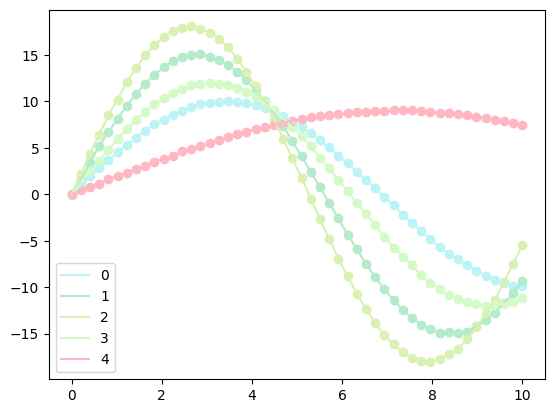

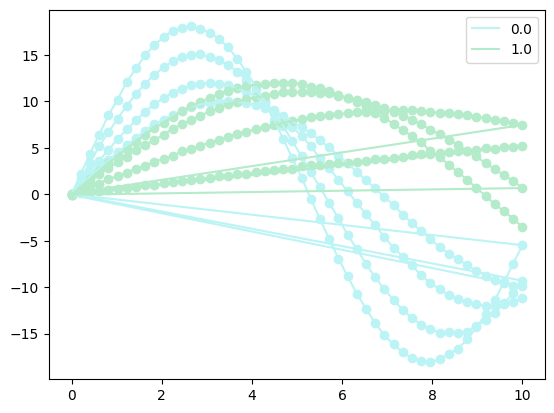

In [6]:
display_pendulum_data(df)

<div class="alert alert-info">
Before running anything, investigate what the prior predictive distribution looks like.
</div>

(400,) (400,) (50,)


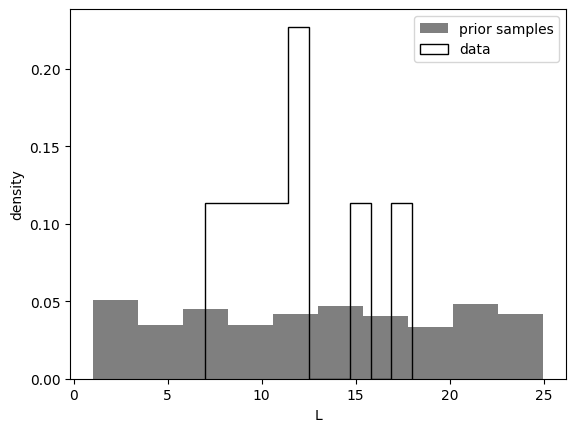

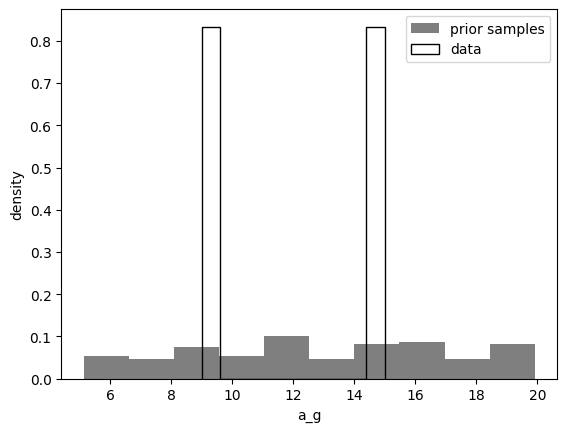

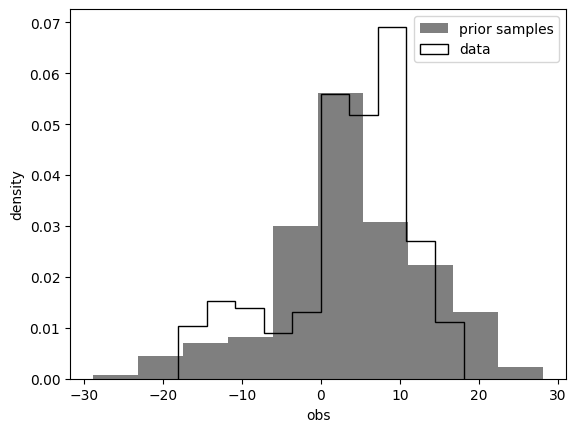

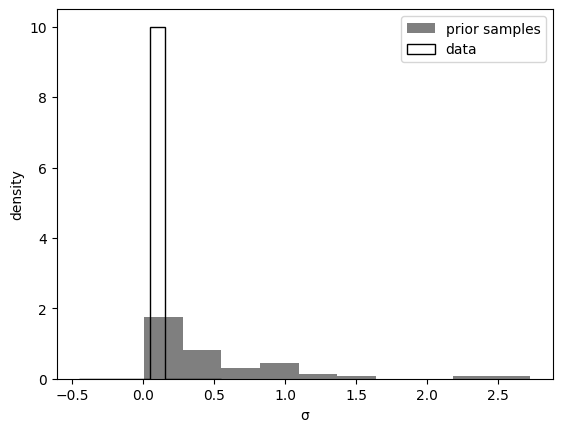

In [12]:
# Generate samples from the prior...

planet_code = df["planet_code"].values
pend_obs = df["pos"].values
time_values = df["time"].values
pend_code = df["pendulum_id"].values

print(np.shape(planet_code), np.shape(pend_code), np.shape(times))
prior_pred = numpyro.infer.Predictive(model, num_samples=50)(
    random.PRNGKey(11), planet_code, pend_code, time_values
)

plot_prior_predictive(prior_pred, "L", "length", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "a_g", "a_g", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "obs", "pos", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "σ", "pos_err", n_steps=10, title = None)


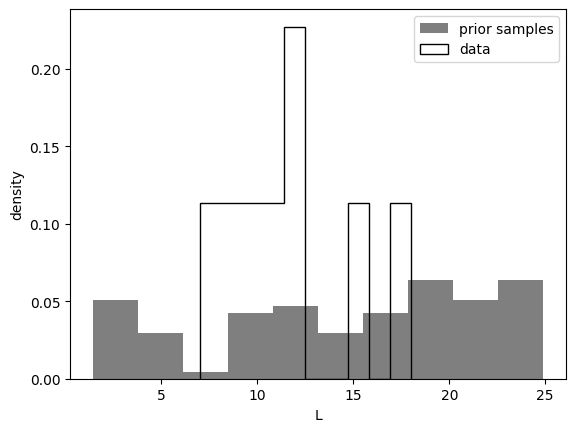

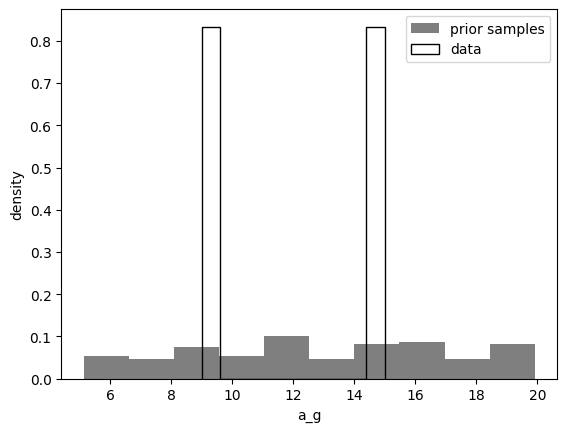

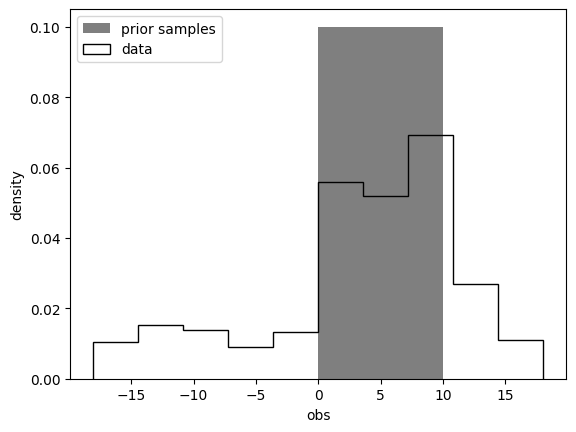

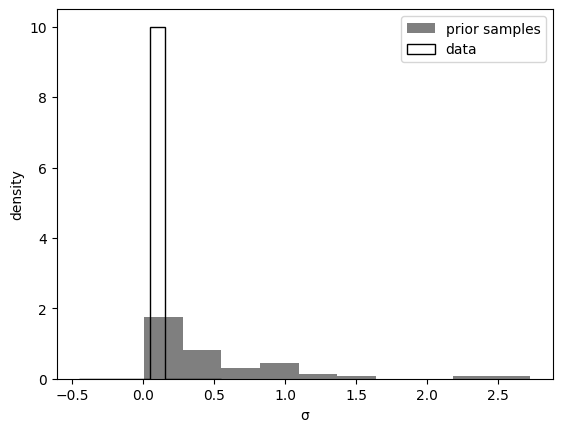

In [13]:
# The same but for the non-hierarchical model
prior_pred = numpyro.infer.Predictive(nonh_model, num_samples=50)(
    random.PRNGKey(11), planet_code, pend_code, time_values
)

plot_prior_predictive(prior_pred, "L", "length", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "a_g", "a_g", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "obs", "pos", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "σ", "pos_err", n_steps=10, title = None)


## Run the inference for the hierarchical case

In [14]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(11)
mcmc.run(rng_key, planet_code, pend_code, time_values, pos_obs=pend_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████████████████████| 4000/4000 [00:15<00:00, 261.60it/s, 63 steps of size 3.56e-02. acc. prob=0.79]


In [15]:
inf_data = az.from_numpyro(mcmc)
az.summary(inf_data)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[0],10.259,0.653,8.982,11.407,0.026,0.019,669.0,355.0,NaN
L[1],14.961,0.615,13.828,16.029,0.017,0.012,1311.0,1229.0,NaN
L[2],18.001,0.595,16.901,19.099,0.016,0.012,1337.0,810.0,NaN
L[3],5.199,0.906,3.524,6.805,0.039,0.027,568.0,798.0,NaN
L[4],9.172,0.592,8.171,10.268,0.019,0.013,1007.0,933.0,NaN
L[5],10.534,4.656,4.303,21.244,0.195,0.138,512.0,581.0,NaN
L[6],10.938,0.640,9.776,12.079,0.020,0.014,1063.0,739.0,NaN
L[7],11.935,0.655,10.744,13.108,0.018,0.013,1323.0,1173.0,NaN
a_g[0],14.853,1.893,10.657,17.864,0.093,0.067,404.0,300.0,NaN
a_g[1],15.330,3.255,9.215,19.976,0.141,0.105,462.0,646.0,NaN


In [ ]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25));

## Visualize it
Some of the classic ways to visualize the output don't work super well with a million pendulums

In [17]:
# so there are sampler chains for each group
print('shape of L samples', np.shape(mcmc.get_samples()['L']))
print('shape of a_g samples', np.shape(mcmc.get_samples()['a_g']))

shape of L samples (2000, 8)
shape of a_g samples (2000, 2)


In [18]:
posterior = mcmc.get_samples()
posterior

{'L': Array([[10.392574 , 15.406804 , 18.98344  , ..., 13.5787525, 10.235201 ,
         12.701506 ],
        [10.068896 , 16.117498 , 19.081474 , ..., 12.76086  , 10.079332 ,
         12.743178 ],
        [10.428178 , 15.289883 , 17.108198 , ...,  5.59548  , 11.596191 ,
         10.783342 ],
        ...,
        [ 9.668416 , 15.371853 , 16.906187 , ...,  8.268247 , 10.905201 ,
         12.09509  ],
        [ 9.498601 , 15.196394 , 16.296215 , ..., 10.924061 , 11.4606695,
         12.425628 ],
        [ 9.90123  , 15.103945 , 16.787144 , ...,  9.114707 , 11.739074 ,
         12.113018 ]], dtype=float32),
 'a_g': Array([[16.159721, 12.925849],
        [16.076414, 10.344134],
        [14.752562, 10.020812],
        ...,
        [14.334566, 18.473866],
        [15.047305, 17.15029 ],
        [15.439092, 19.086243]], dtype=float32),
 'theta': Array([[1.432492  , 1.0691577 , 0.9838811 , ..., 0.0576584 , 0.7122092 ,
         0.6389298 ],
        [1.5143753 , 1.0573424 , 0.9852665 , ..., 0.054

Pendulum number 0
true L = 10.0
posterior L = 10.260000228881836 +/- 0.6499999761581421
true theta = 0.7853981633974482
posterior theta = 1.3300000429153442 +/- 0.1899999976158142
true a_g = 9.0
posterior a_g = 15.079999923706055 +/- 1.8899999856948853


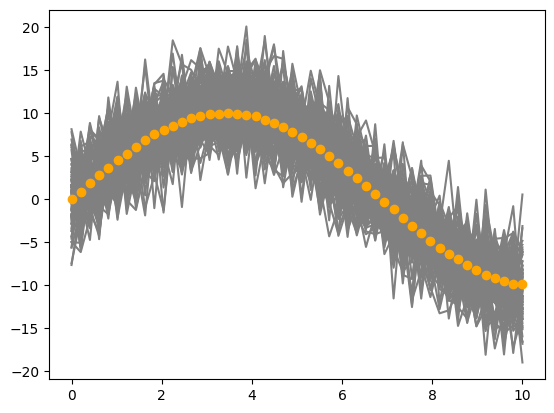

Pendulum number 1
true L = 15.0
posterior L = 14.949999809265137 +/- 0.6100000143051147
true theta = 0.7853981633974482
posterior theta = 1.0399999618530273 +/- 0.10999999940395355
true a_g = 9.0
posterior a_g = 16.06999969482422 +/- 3.25


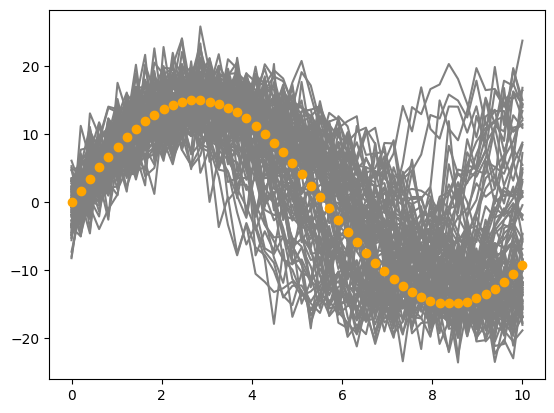

Pendulum number 2
true L = 18.0
posterior L = 18.0 +/- 0.5899999737739563
true theta = 0.7853981633974482
posterior theta = 0.9800000190734863 +/- 0.07000000029802322
true a_g = 9.0
posterior a_g = 16.06999969482422 +/- 3.25


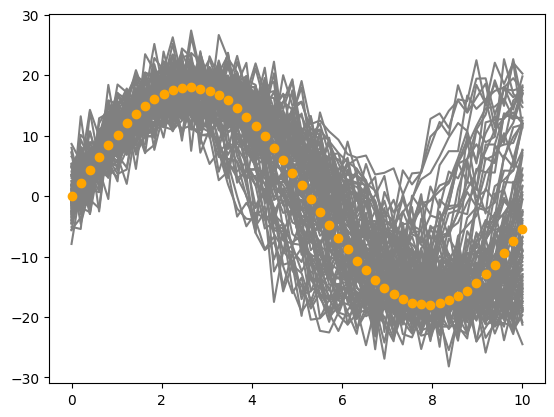

Pendulum number 3
true L = 12.0
posterior L = 5.309999942779541 +/- 0.9099999666213989
true theta = 0.7853981633974482
posterior theta = 0.7200000286102295 +/- 0.3999999761581421
true a_g = 9.0
posterior a_g = 16.06999969482422 +/- 3.25


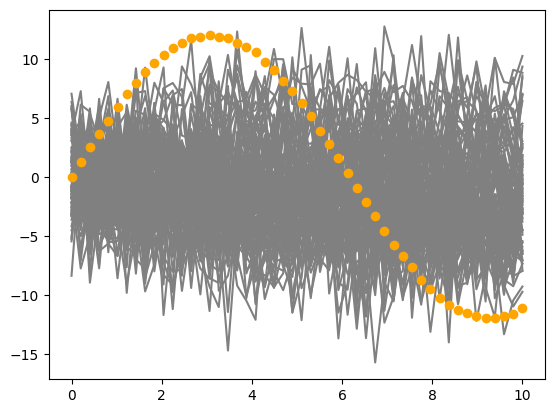

Pendulum number 4
true L = 9.0
posterior L = 9.180000305175781 +/- 0.5899999737739563
true theta = 0.7853981633974482
posterior theta = 0.8700000047683716 +/- 0.3499999940395355
true a_g = 15.0
posterior a_g = 16.06999969482422 +/- 3.25


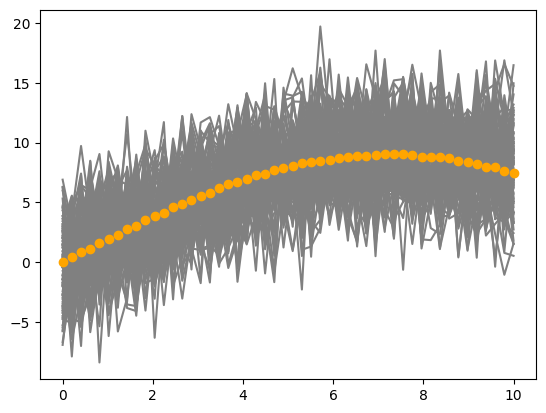

Pendulum number 5
true L = 7.0
posterior L = 8.930000305175781 +/- 4.659999847412109
true theta = 0.7853981633974482
posterior theta = 0.2800000011920929 +/- 0.3999999761581421
true a_g = 15.0
posterior a_g = 16.06999969482422 +/- 3.25


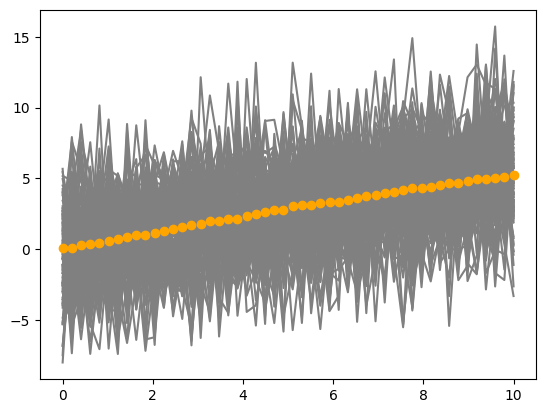

Pendulum number 6
true L = 11.0
posterior L = 10.930000305175781 +/- 0.6399999856948853
true theta = 0.7853981633974482
posterior theta = 0.8700000047683716 +/- 0.25999999046325684
true a_g = 15.0
posterior a_g = 16.06999969482422 +/- 3.25


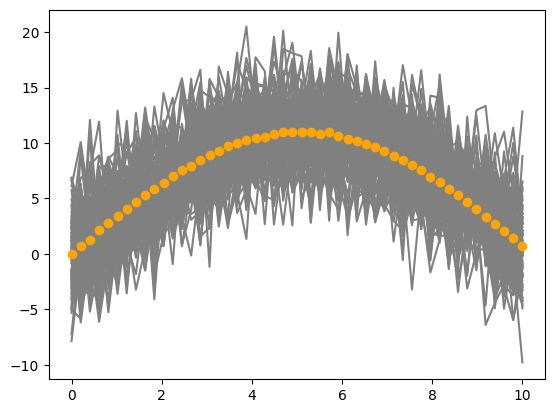

Pendulum number 7
true L = 12.0
posterior L = 11.930000305175781 +/- 0.6599999666213989
true theta = 0.7853981633974482
posterior theta = 0.8600000143051147 +/- 0.2199999988079071
true a_g = 15.0
posterior a_g = 16.06999969482422 +/- 3.25


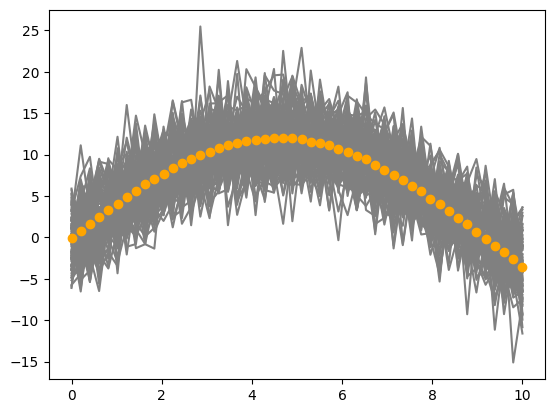

In [20]:
how_did_we_do_on_individual_pendulums(df, posterior, 8, 2000)

(2000,)


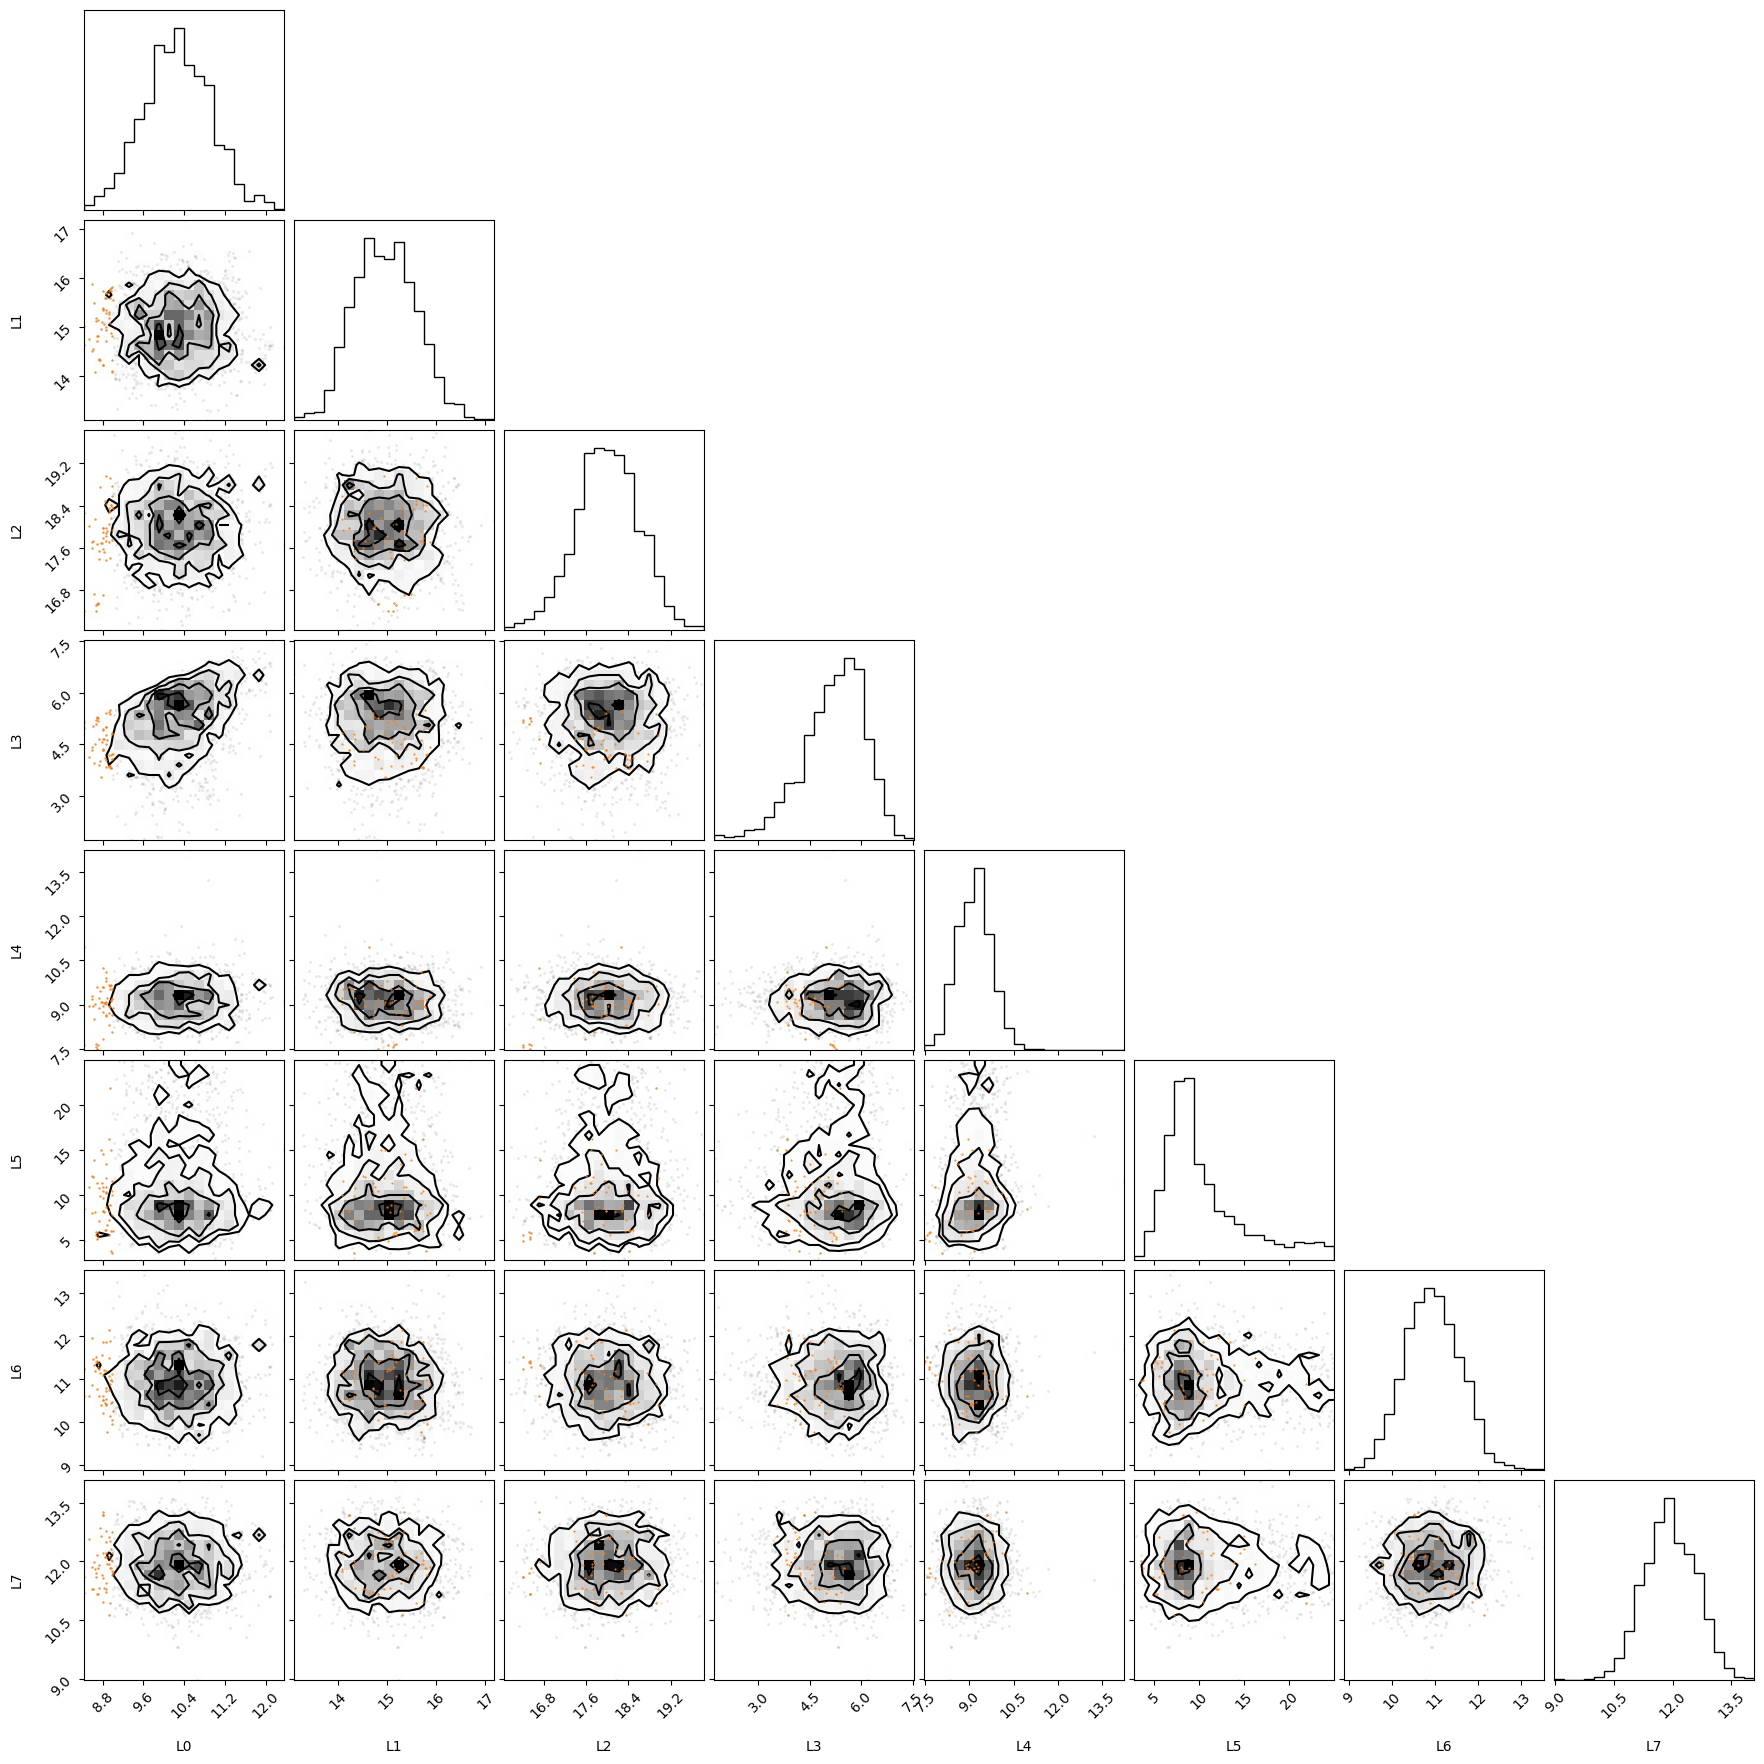

In [37]:
print(np.shape(posterior["L"][:,0]))
data = az.from_dict(
    posterior={"L0": posterior["L"][:,0], "L1": posterior["L"][:,1],
               "L2": posterior["L"][:,2], "L3": posterior["L"][:,3],
               "L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
               "L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
               },
    sample_stats={"diverging": posterior["L"][:,0] < 9.0},
)

figure = corner.corner(data, divergences=True)

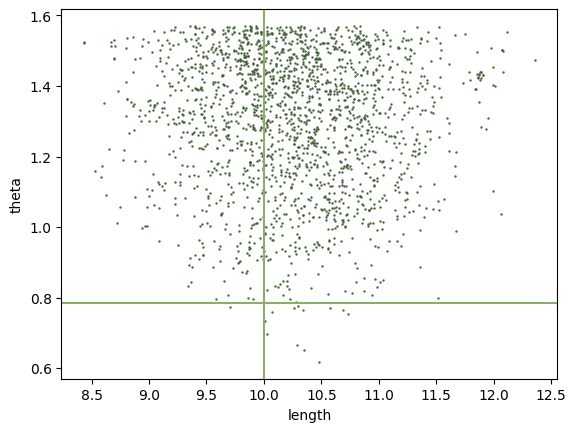

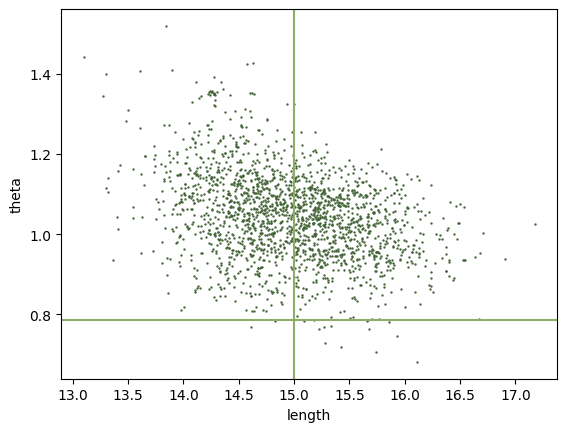

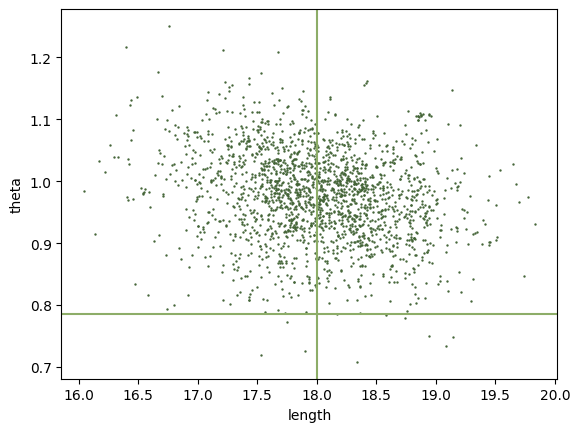

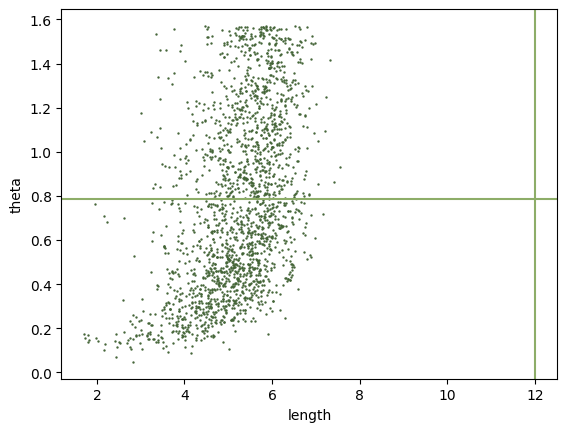

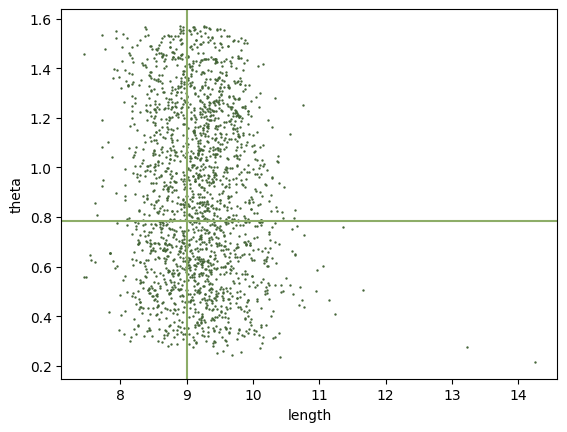

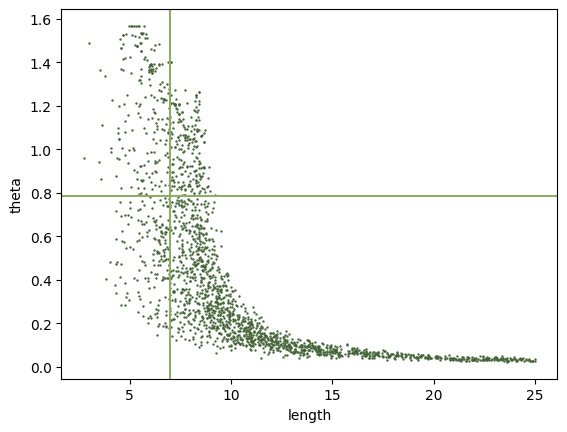

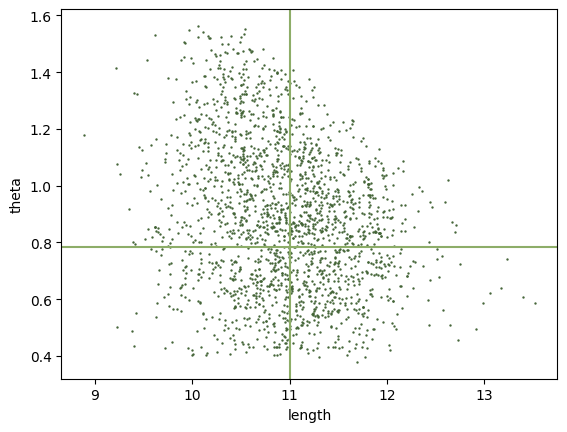

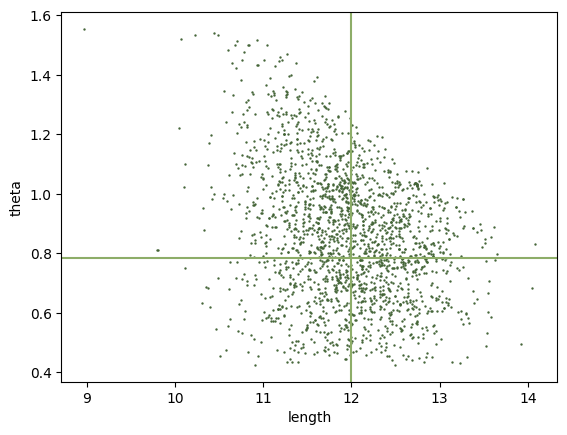

In [28]:
def custom_corner_plot():
    

# It would be great if there is some way to create your own corner plot with the parameters
plt.clf()
for number in np.unique(df['pend_code']):

    plt.scatter(posterior['L'][:,number],posterior['theta'][:,number],
                color = '#436436', s = 0.5)
    plt.axvline(x = np.mean(df[df['pend_code'] == number]['length']), color = '#8DAD68')
    plt.axhline(y = np.mean(df[df['pend_code'] == number]['theta']), color = '#8DAD68')
    plt.xlabel('length')
    plt.ylabel('theta')
    plt.show()


In [ ]:
# figure out what's going on with the parameters that are individual for each pendulum
plt.clf()
for number in np.unique(df['pend_code']):
    plt.plot(mcmc.get_samples()['L'][:,number], color = '#436436')
    plt.axhline(y = np.mean(df[df['pend_code'] == number]['length']), color = '#8DAD68')
    plt.axhline(y = np.mean(mcmc.get_samples()['L'][:,number]) - np.std(mcmc.get_samples()['L'][:,number]), 
                color = 'black', ls = '--')
    plt.axhline(y = np.mean(mcmc.get_samples()['L'][:,number]) + np.std(mcmc.get_samples()['L'][:,number]), 
            color = 'black', ls = '--')

    plt.ylabel('L')
    plt.show()
df

In [ ]:
# figure out what's going on with the parameters that are individual for each pendulum
plt.clf()
for number in np.unique(df['pend_code']):
    plt.plot(mcmc.get_samples()['theta'][:,number], color = '#436436')
    plt.axhline(y = np.mean(df[df['pend_code'] == number]['theta']), color = '#8DAD68')
    plt.axhline(y = np.mean(mcmc.get_samples()['theta'][:,number]) - np.std(mcmc.get_samples()['theta'][:,number]), 
                color = 'black', ls = '--')
    plt.axhline(y = np.mean(mcmc.get_samples()['theta'][:,number]) + np.std(mcmc.get_samples()['theta'][:,number]), 
            color = 'black', ls = '--')

    plt.ylabel('theta')
    plt.show()

In [ ]:
plt.clf()
plt.plot(mcmc.get_samples()['a_g'][:,1], color = '#436436')
plt.axhline(y = np.mean(df[df['planet_code'] == 1]['a_g']), color = '#8DAD68')
plt.axhline(y = np.mean(mcmc.get_samples()['a_g'][:,1]) - np.std(mcmc.get_samples()['a_g'][:,1]), 
            color = 'black', ls = '--')
plt.axhline(y = np.mean(mcmc.get_samples()['a_g'][:,1]) + np.std(mcmc.get_samples()['a_g'][:,1]), 
            color = 'black', ls = '--')

plt.ylabel('a_g')

plt.plot(mcmc.get_samples()['a_g'][:,0], color = '#ADB9E3')
plt.axhline(y = np.mean(df[df['planet_code'] == 0]['a_g']), color = '#A379C9')
plt.ylabel('a_g')
plt.show()
df

ValueError: Dimension mismatch between bins and range

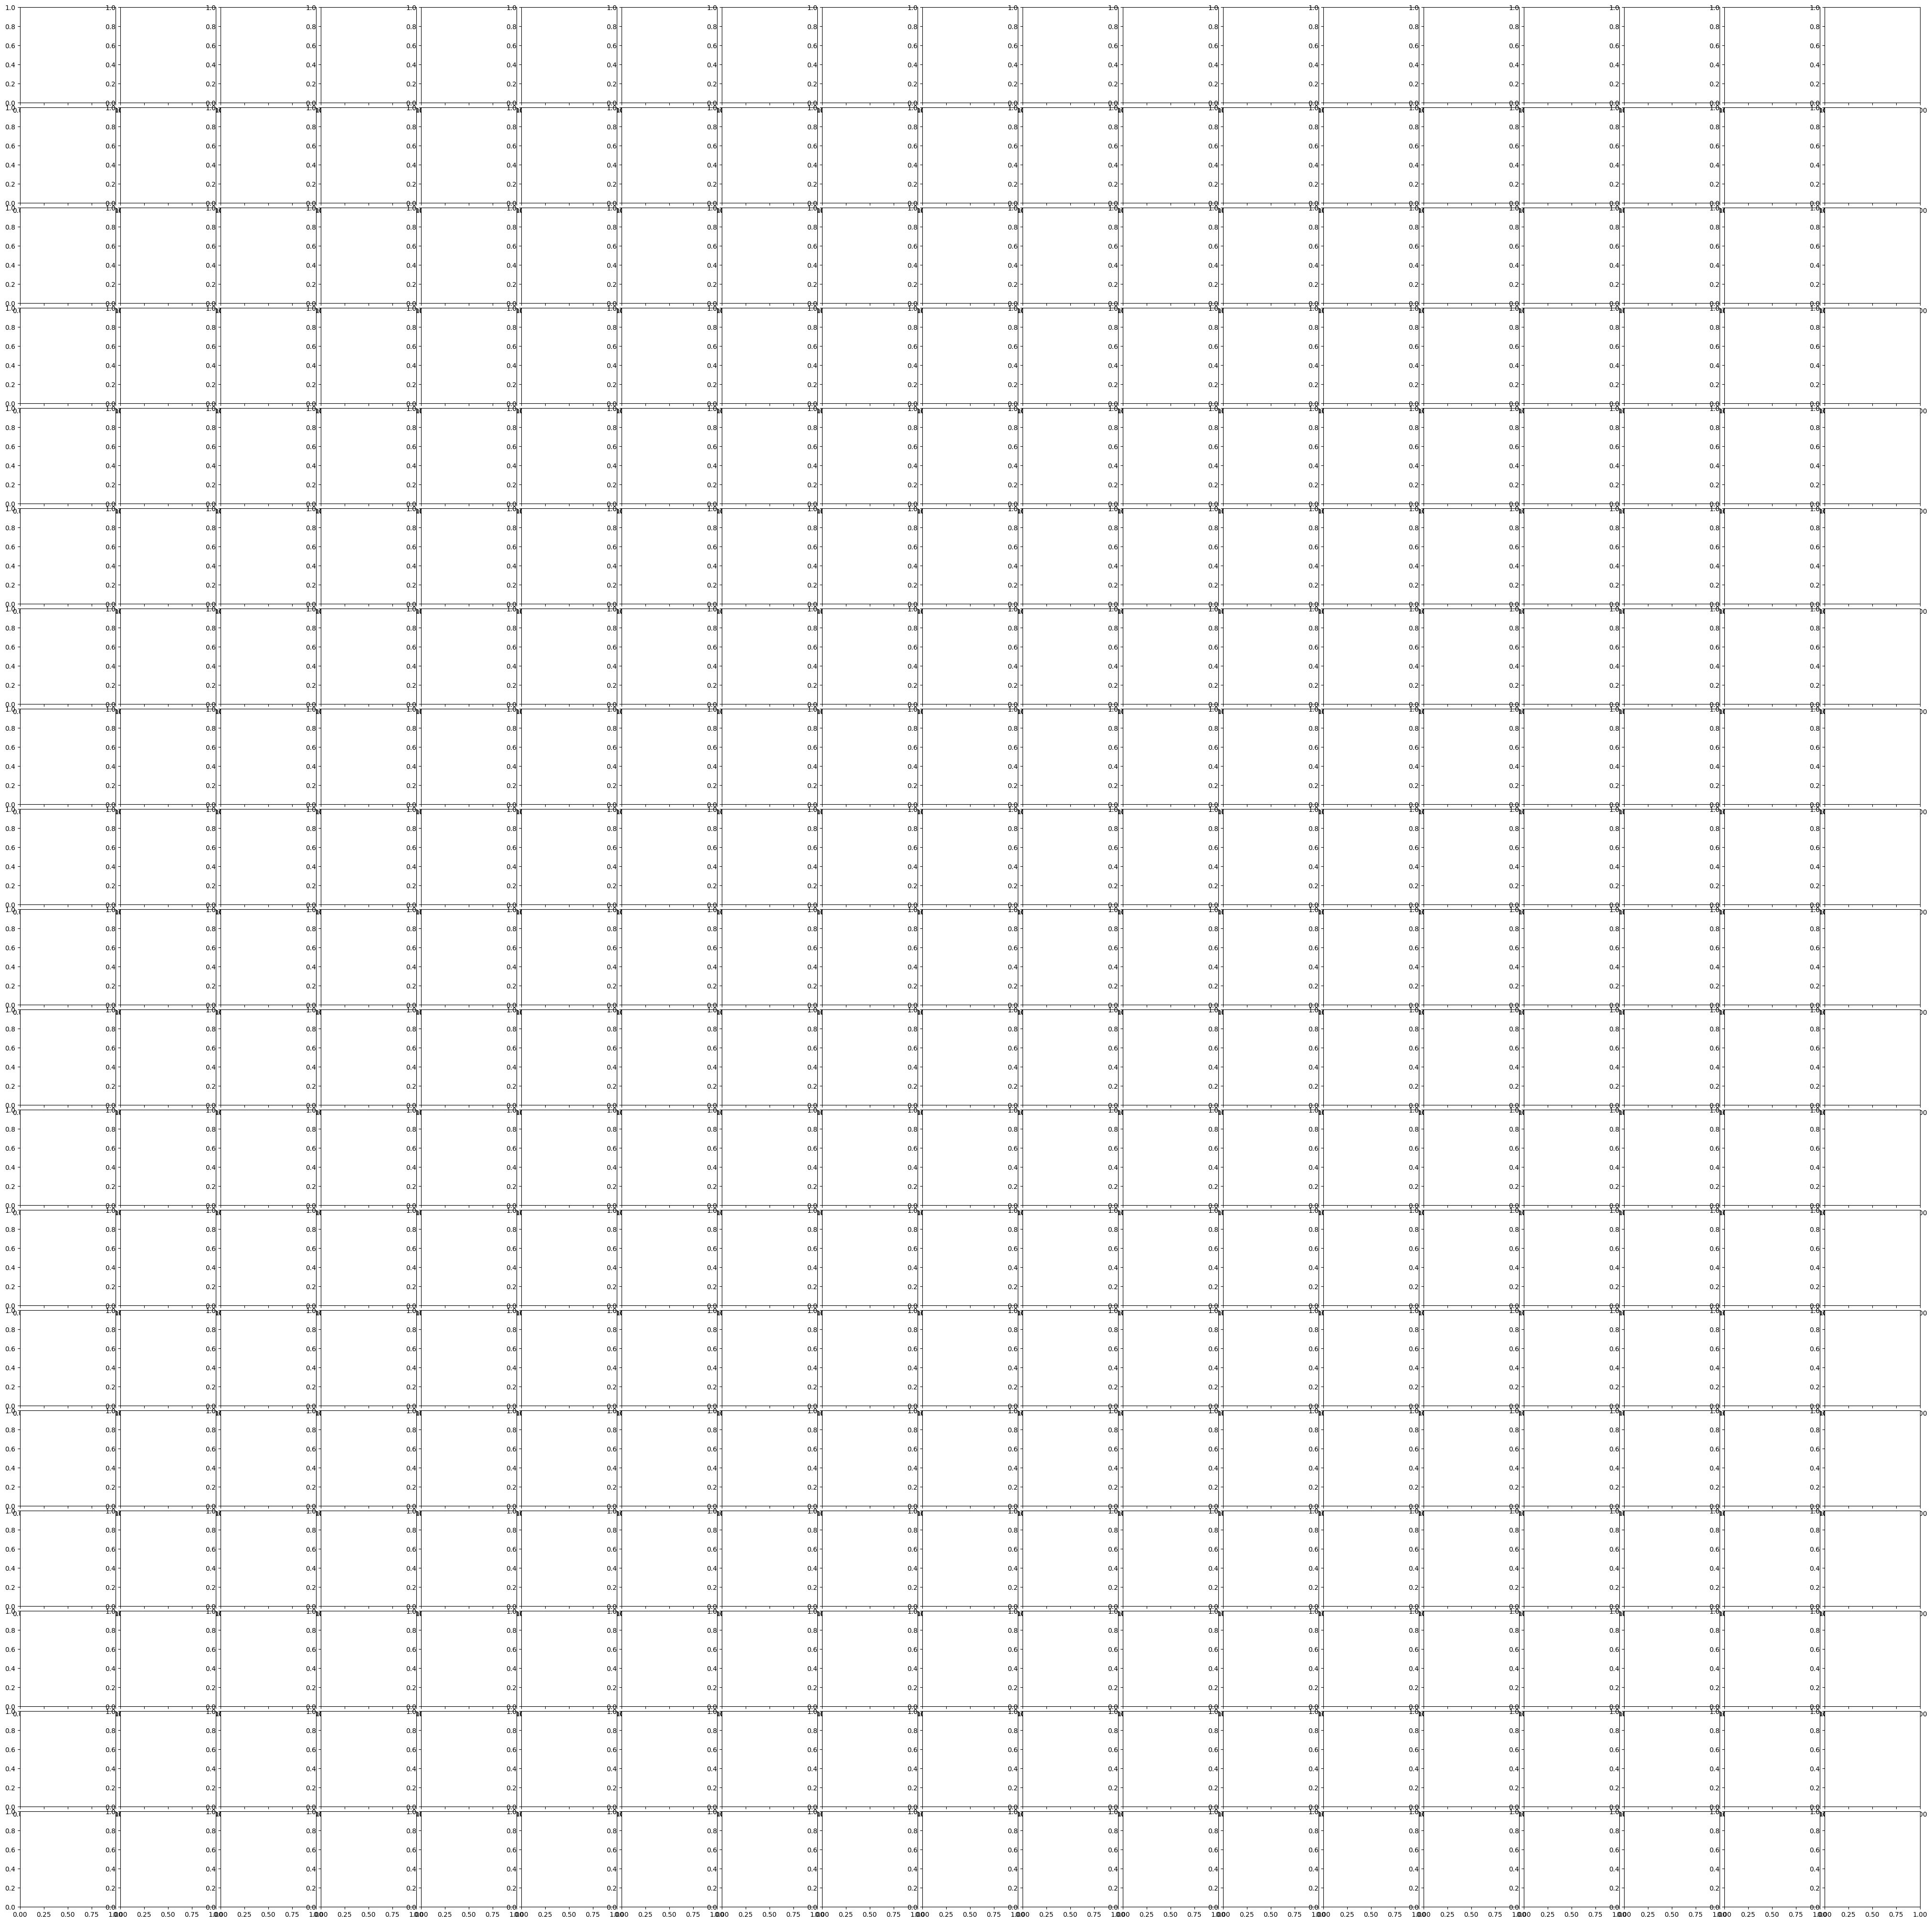

In [30]:
# This is the overall sampler
corner.corner(inf_data, ["L1","L2"]);

In [ ]:
print(np.shape(mcmc.get_samples()['a_g'][:,1]))

In [ ]:
plt.clf()
plt.plot(mcmc.get_samples()['a_g'][:,1])
plt.ylabel('a_g')
plt.show()

## Now run the inference for the non-hierarchical case

In [22]:
nuts_kernel_nonh = NUTS(nonh_model)

mcmc_nonh = MCMC(nuts_kernel_nonh, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(11)
mcmc_nonh.run(rng_key, pend_code, time_values, pos_obs=pend_obs)


sample: 100%|█████████████████████████| 4000/4000 [00:20<00:00, 198.23it/s, 127 steps of size 3.33e-02. acc. prob=0.91]


In [23]:
inf_data_nonh = az.from_numpyro(mcmc_nonh)
az.summary(inf_data_nonh)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[0],10.080,0.878,8.546,11.835,0.015,0.011,3319.0,1433.0,NaN
L[1],14.937,0.860,13.363,16.543,0.015,0.011,3313.0,1440.0,NaN
L[2],6.627,0.550,5.671,7.524,0.016,0.011,1549.0,808.0,NaN
L[3],12.069,0.793,10.621,13.522,0.014,0.010,3072.0,1780.0,NaN
L[4],9.466,1.502,7.388,11.187,0.073,0.057,1253.0,517.0,NaN
L[5],9.435,5.064,3.437,21.110,0.164,0.126,1331.0,967.0,NaN
L[6],10.908,0.883,9.175,12.503,0.016,0.011,3011.0,1337.0,NaN
L[7],11.855,0.888,10.231,13.621,0.017,0.012,2631.0,1240.0,NaN
a_g[0],11.704,3.399,5.369,16.969,0.077,0.056,1801.0,1222.0,NaN
a_g[1],13.452,4.261,6.304,19.986,0.119,0.089,1212.0,1165.0,NaN


In [ ]:
data_nonh = az.from_numpyro(mcmc_nonh)
az.plot_trace(data_nonh, compact=True, figsize=(15, 25));

In [25]:
posterior_nonh = mcmc_nonh.get_samples()
posterior_nonh

{'L': Array([[11.309996 , 15.4655   ,  6.4609194, ...,  4.985011 , 11.572364 ,
         11.262822 ],
        [11.128227 , 15.43298  ,  6.5224056, ...,  5.5856023, 11.509399 ,
         11.557945 ],
        [ 7.6728425, 14.989649 ,  6.500052 , ...,  6.1885467, 10.733071 ,
         12.18742  ],
        ...,
        [ 9.704355 , 13.680916 ,  6.4170947, ..., 12.74716  , 10.399294 ,
         13.043926 ],
        [ 9.653372 , 14.220007 ,  6.4489527, ...,  3.1177237, 10.965067 ,
         10.711812 ],
        [10.367349 , 14.047863 ,  6.5987654, ...,  7.3905945,  9.732441 ,
         12.664847 ]], dtype=float32),
 'a_g': Array([[ 8.263617 ,  5.994671 , 18.008986 , ...,  7.979878 , 10.046548 ,
         19.520792 ],
        [ 7.625848 ,  6.42871  , 18.368402 , ...,  9.657866 ,  9.360864 ,
         19.82981  ],
        [10.637424 , 16.831024 , 18.985376 , ..., 13.379853 , 18.223743 ,
         17.585129 ],
        ...,
        [ 9.654063 , 17.577124 , 17.325974 , ..., 17.940634 ,  6.0217996,
       

Pendulum number 0
true L = 10.0
posterior L = 10.079999923706055 +/- 0.8799999952316284
true theta = 0.7853981633974482
posterior theta = 1.0 +/- 0.26999998092651367
true a_g = 9.0
posterior a_g = 11.90999984741211 +/- 3.3999998569488525


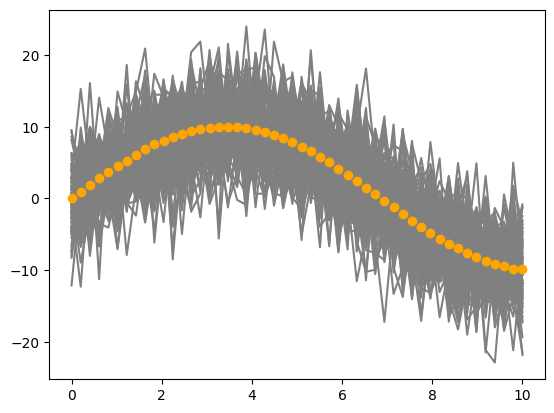

Pendulum number 1
true L = 15.0
posterior L = 14.960000038146973 +/- 0.85999995470047
true theta = 0.7853981633974482
posterior theta = 0.9800000190734863 +/- 0.2199999988079071
true a_g = 9.0
posterior a_g = 13.90999984741211 +/- 4.259999752044678


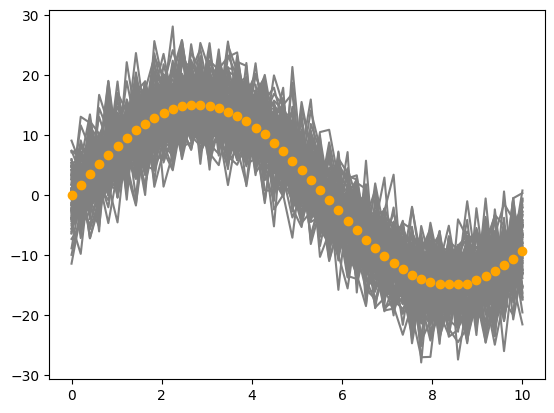

Pendulum number 2
true L = 18.0
posterior L = 6.71999979019165 +/- 0.550000011920929
true theta = 0.7853981633974482
posterior theta = 1.090000033378601 +/- 0.3100000023841858
true a_g = 9.0
posterior a_g = 19.030000686645508 +/- 1.1299999952316284


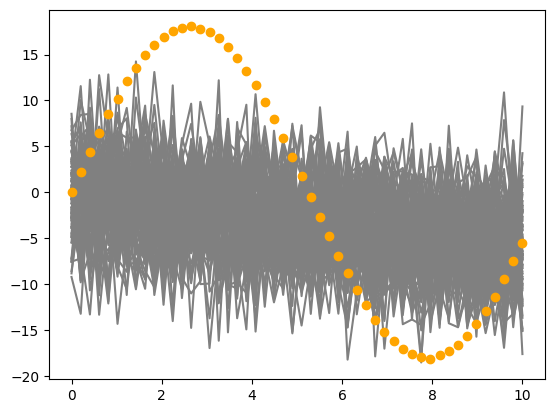

Pendulum number 3
true L = 12.0
posterior L = 12.069999694824219 +/- 0.7899999618530273
true theta = 0.7853981633974482
posterior theta = 1.0299999713897705 +/- 0.26999998092651367
true a_g = 9.0
posterior a_g = 13.270000457763672 +/- 4.019999980926514


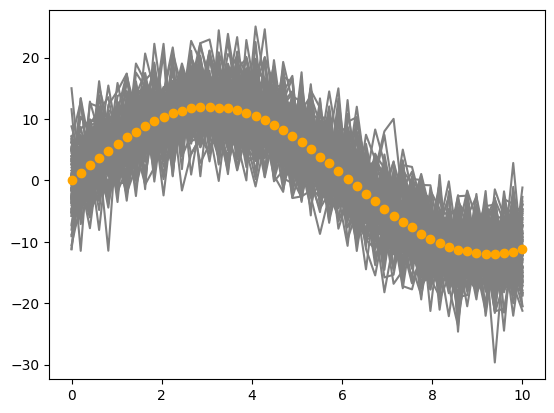

Pendulum number 4
true L = 9.0
posterior L = 9.289999961853027 +/- 1.5
true theta = 0.7853981633974482
posterior theta = 0.6200000047683716 +/- 0.3700000047683716
true a_g = 15.0
posterior a_g = 14.59000015258789 +/- 4.029999732971191


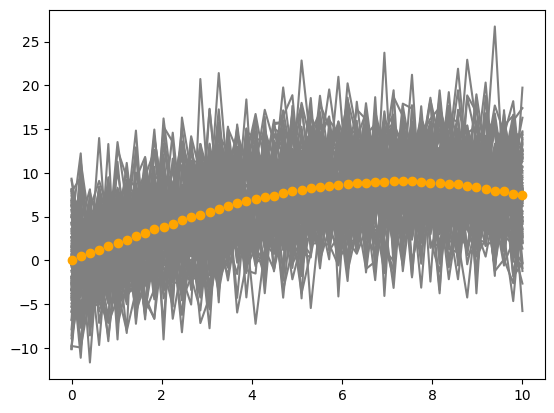

Pendulum number 5
true L = 7.0
posterior L = 7.829999923706055 +/- 5.059999942779541
true theta = 0.7853981633974482
posterior theta = 0.3100000023841858 +/- 0.4099999964237213
true a_g = 15.0
posterior a_g = 12.069999694824219 +/- 4.21999979019165


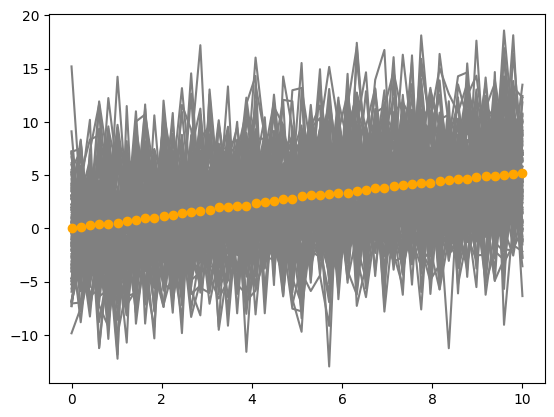

Pendulum number 6
true L = 11.0
posterior L = 10.880000114440918 +/- 0.8799999952316284
true theta = 0.7853981633974482
posterior theta = 0.7699999809265137 +/- 0.3100000023841858
true a_g = 15.0
posterior a_g = 14.6899995803833 +/- 4.21999979019165


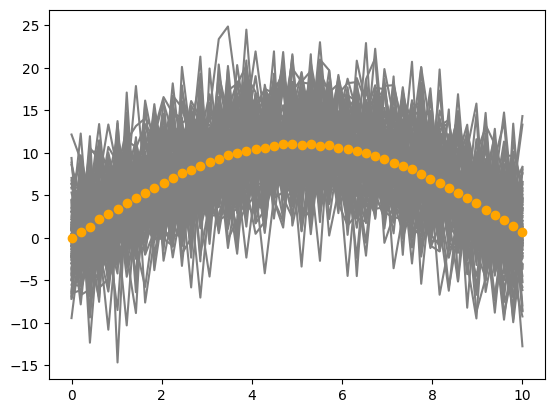

Pendulum number 7
true L = 12.0
posterior L = 11.859999656677246 +/- 0.8899999856948853
true theta = 0.7853981633974482
posterior theta = 0.7599999904632568 +/- 0.26999998092651367
true a_g = 15.0
posterior a_g = 14.510000228881836 +/- 4.279999732971191


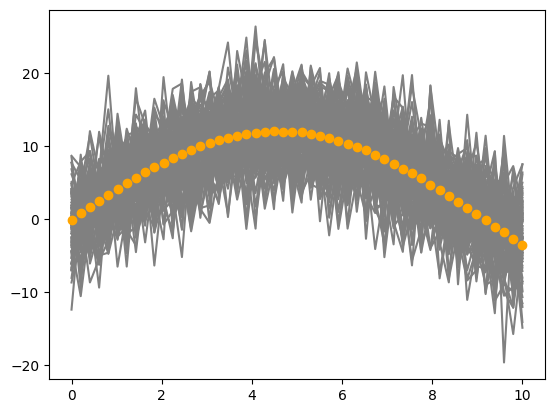

In [27]:
how_did_we_do_on_individual_pendulums(df, posterior_nonh, 8, 2000)